# Coherent atto-spikes from the _spiral_ beam in a matched channel

This example is inspired by the work on the superradiance of [**Viera et al Nat Phys 2020**](https://www.nature.com/articles/s41567-020-0995-5). Here we consider a case of a spiral beam propagating in a matched focusing plasma channel.

In this furst part, we roughly compare coherent and incoherent radiation produced by the _winding_ and _betatron_ motions of the beam. Coherent (Vavilov-Cherenkov) and incoherent (betatron) emissions are produced in the different agular-spectral regions, but for the generality both calculations are done in the same limits.

More details on the coherent part inculding its temporal reconstrutions can be found in **Part 2**

In [1]:
%matplotlib inline

import numpy as np
from copy import deepcopy

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from synchrad.calc import SynchRad
from synchrad.utils import r_e, omega_1m, alpha_fs

from scipy.constants import e, m_e, c, epsilon_0, hbar
from scipy.integrate import solve_ivp

from tqdm import tqdm

In [2]:
############# Parameters #############

particle_energy_MeV = 100    # particle energy (MeV)
n_p = 5e18 * 1e6             # Plasma density (m^-3)

N_winds = 1                  # Number of spiral rotations
L_b = 0.4e-6                 # Beam length (m)
energy_spread = 0.001        # relative energy spread
pr_spread = 0.0              # relative spread of transverse momenta

Np = 16000                    # Number of electrons
Num_osc = 3                  # Number of oscillations to perform
StepsPerOsc = 64             # Motion resolution
K0 = 4.                      # Undulator strength (defines spiral radius)

############# Technical Parameters #############

gamma_0 = particle_energy_MeV * 1e6 * e / (m_e * c**2)
pz0 = ( gamma_0**2 -  K0**2 - 1 )**.5

omega_p = c * ( 4 * np.pi * r_e * n_p)**0.5 
omega_ch = omega_p / (2 * gamma_0)**0.5
R_match = K0 * c/omega_p * (2/gamma_0)**0.5

lambda_ch = 2 * np.pi * c / omega_ch

omega_ch_und = 2 * gamma_0**2 * omega_ch  / (1 + K0**2)
omega_ch_crit = 3/2 * K0 * gamma_0**2 * omega_ch

lam_z = L_b / N_winds
k_siprl = 2 * np.pi / lam_z
omega_VC = k_siprl * c

beta_phs = pz0 / gamma_0 + omega_ch / omega_VC
theta_vc = np.arccos( 1/ beta_phs )
theta_beta = K0/gamma_0

L_ch =  Num_osc * lambda_ch
T_fin  = L_ch / c
Nt = L_ch / lambda_ch * StepsPerOsc

print(f"\tCherenkov angle: {theta_vc*1e3:.1f} mrad\n",
      f"\tIncoherent emission angle: {theta_beta*1e3:.1f} mrad")

	Cherenkov angle: 47.6 mrad
 	Incoherent emission angle: 20.4 mrad


In [3]:
############# Initial beam data #############

z = np.linspace(0, L_b, Np)
if Np > 1:
    dz = z[1]-z[0]
    z = z + 0.5*dz*(np.random.rand(z.size)-0.5)

x = R_match * np.sin(k_siprl * z)
y = R_match * np.cos(k_siprl * z)

ux = - K0 * np.cos(k_siprl * z) * (1 + pr_spread * np.random.randn(Np))
uy = K0 * np.sin(k_siprl * z) * (1 + pr_spread * np.random.randn(Np))

uz = pz0 * (1 + energy_spread * np.random.randn(Np))
trak0 = np.array([x, y, z, ux, uy, uz])

In [4]:
############# Model particles motion #############

def motion_channel(t, track, omega_p):
    x, y, z, ux, uy, uz = track
    
    gamma_p = np.sqrt(1.0 + ux**2 + uy**2 +  uz**2)
    
    dx = c * ux / gamma_p
    dy = c * uy / gamma_p
    dz = c * uz / gamma_p
    
    dux = - 0.5 * omega_p**2 / c * x
    duy = - 0.5 * omega_p**2 / c * y
    duz = 0.0
    
    return dx, dy, dz, dux, duy, duz


## Cooridnates and momenta are staggered in time by half-step

t_eval = np.r_[0: T_fin: 1j * Nt]
dt = t_eval[1] - t_eval[0]
tracks = []

for ip in tqdm(range(Np)):
    x_, y_, z_, ux, uy, uz = solve_ivp( motion_channel, [0, T_fin], trak0[:, ip], 
                                        t_eval=t_eval, args=(omega_p,),
                                        method='Radau' ).y
    
    x, y, z, ux_, uy_, uz_ = solve_ivp( motion_channel, [0, T_fin+dt/2], trak0[:, ip], 
                                        t_eval=t_eval+dt/2, args=(omega_p,),
                                        method='Radau' ).y
    
    tracks.append([x, y, z, ux, uy, uz, 1.0, 0.0])

100%|██████████| 16000/16000 [04:34<00:00, 58.26it/s]


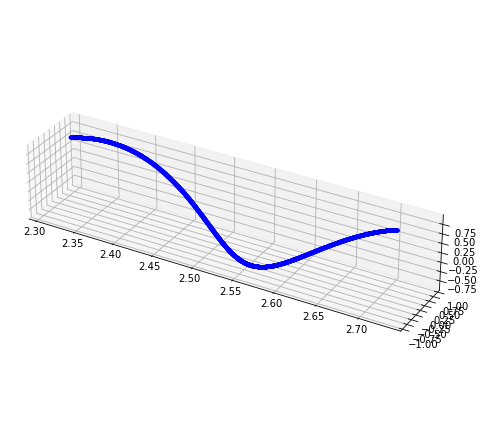

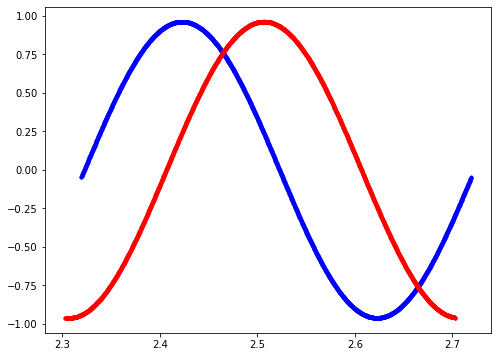

In [5]:
#### 3D plot of the beam ####

fig = plt.figure(figsize=(8,6))
ax = Axes3D(fig, box_aspect=(5,1,1))
for track in tracks[::8]:
    x, y, z, ux, uy, uz, w, id_start = track
    x, y, z = x*1e6, y*1e6, z*1e6
    it=0
    ax.plot(z[it], x[it], y[it], '.', c='b')
    
#### plot of the beam in (Z-X) plane at two times
#### beam is subluminal, but spiral phase is superluminal

fig = plt.figure(figsize=(8,6))
for track in tracks[::8]:
    x, y, z, ux, uy, uz, w, id_start = track
    x, y, z = x*1e6, y*1e6, z*1e6
    it=0
    plt.plot(z[it] - it*dt*c*1e6, x[it], '.', c='b')
    it=16
    plt.plot(z[it] - it*dt*c*1e6, x[it], '.', c='r')

In [6]:
#### Setup and run SynchRad calculations


theta_max = 1.2*np.max([theta_beta, theta_vc])

calc_input = {
    "grid": [
        (1. , 3*omega_ch_crit/omega_1m),  
        (0, theta_max),
        (0.0, 2 * np.pi),
        (1024, 32, 32),
    ],  
}

calc_incoh = SynchRad(deepcopy(calc_input))
calc_coh = SynchRad(deepcopy(calc_input))

calc_incoh.calculate_spectrum( particleTracks=tracks,
                               Np_max=1000,            # No need for higher Np
                               timeStep=c*dt )

calc_coh.calculate_spectrum( particleTracks=tracks,
                             comp='cartesian_complex',
                             timeStep=c*dt )

Running on 1 devices
  ALL | GPU device: TITAN RTX
Platform: NVIDIA Corporation
Compiler: OpenCL C 1.2 
Running on 1 devices
  ALL | GPU device: TITAN RTX
Platform: NVIDIA Corporation
Compiler: OpenCL C 1.2 
Separate it_range for each track will be used
Separate it_range for each track will be used


Enhancement due to coherency 12.5


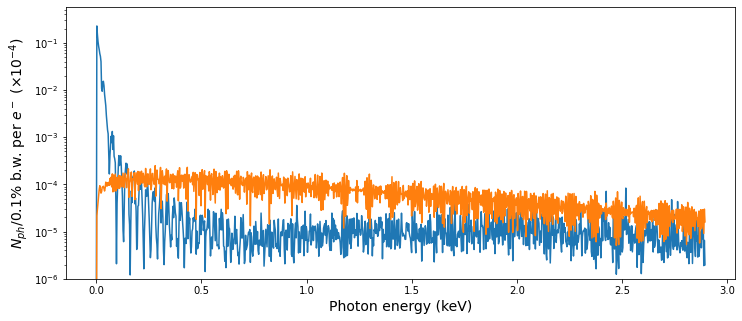

In [7]:
plt.figure(figsize=(12,5))

for calc in [calc_coh, calc_incoh]:
    spect_val = calc.get_energy_spectrum(normalize_to_weights=True)
    spect_val *= 1e-3
    spect_ax_keV = calc.get_spectral_axis()  * 1.24e-6 * 1e-3 
    spect_ax_norm = calc.get_spectral_axis() * omega_1m/omega_ch_crit
    plt.semilogy(spect_ax_keV, spect_val )
    
plt.ylim(1e-6, )
    
plt.xlabel(r'Photon energy (keV)', fontsize=14)
plt.ylabel(r'$N_{ph}$/0.1% b.w. per $e^-$ ($\times 10^{-4}$)', fontsize=14)   
    
coherent_gain = calc_coh.get_energy(normalize_to_weights=True, lambda0_um=1e6) \
                / calc_incoh.get_energy(normalize_to_weights=True, lambda0_um=1e6)

print(f'Enhancement due to coherency {coherent_gain:.1f}')

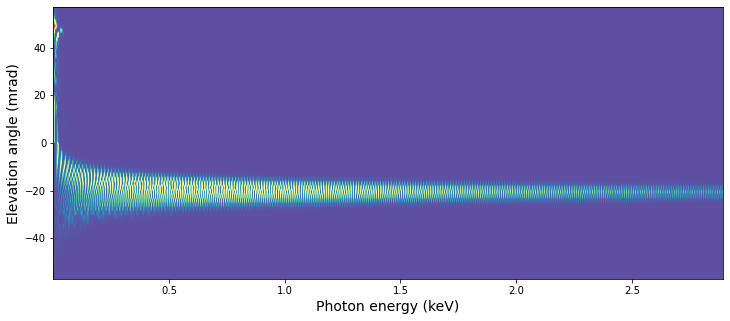

In [8]:
### Plot coherent emission in th>0 and incoherent in th<0 (nomalized amplitude)

spect_ax_keV = calc_incoh.get_spectral_axis()  * 1.24e-6 * 1e-3

spect_incoh = calc_incoh.get_full_spectrum()
spect_incoh = spect_incoh/spect_incoh.max()
spect_coh = calc_coh.get_full_spectrum() 
spect_coh = spect_coh/ spect_coh.max()

spect_val = np.c_[spect_incoh[:,:,0][:,::-1], spect_coh[:,:,0], ]

extent = [spect_ax_keV.min(), 
          spect_ax_keV.max(), 
          -calc_incoh.Args['theta'].max()* 1e3,
           calc_incoh.Args['theta'].max()* 1e3 ]

plt.figure(figsize=(12,5))
plt.imshow( spect_val.T,
            extent = extent,
            cmap=plt.cm.Spectral_r,
            origin='lower', 
           aspect='auto' )
plt.xlabel('Photon energy (keV)', fontsize=14)
plt.ylabel('Elevation angle (mrad)', fontsize=14);

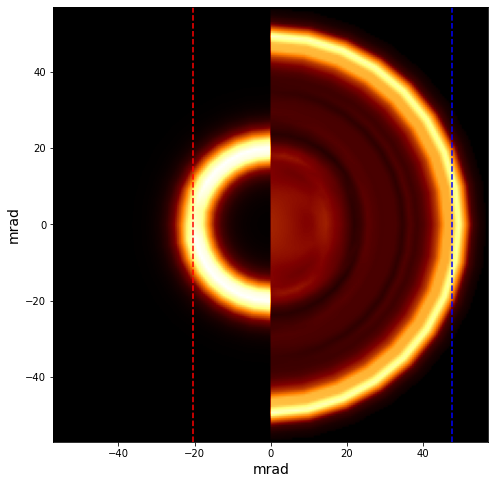

In [9]:
plt.figure(figsize=(8,8))

spot_full = 0
spot, extent = calc_incoh.get_spot_cartesian(bins=(200, 200))
x = np.linspace(extent[0],extent[1],200)
spot = spot/spot.max()
spot_full += spot * (x<0)[:,None]

x = np.linspace(extent[0],extent[1],200)
spot, extent = calc_coh.get_spot_cartesian(bins=(200, 200))
spot = spot/spot.max()
spot_full += spot * (x>0)[:,None]

plt.imshow(spot_full.T, extent=extent*1e3, cmap=plt.cm.afmhot, origin='lower')
[ lab('mrad', size=14) for lab in (plt.xlabel, plt.ylabel) ];

plt.plot( -1e3*theta_beta * np.ones_like(x), x*1e3, '--', c='r')
plt.plot( 1e3*theta_vc * np.ones_like(x), x*1e3, '--', c='b');